# Credit Card Fraud Detection System

This notebook contains my approach towards credit card fraud detection using Machine Learning Algorithms. Credit card fraud detection is a very serious modern day problem. In this notebook my aim will be to get the maximum possible accuracy for the European Tracsaction data set which was released in 2013. The metrics I will be using is F1- Score, Precision and Recall.

We will first import the necessary libraries for EDA:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore")

from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn import metrics
from sklearn.metrics import auc, f1_score, plot_roc_curve, precision_score, recall_score

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

Now let us import the data we have:

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Now let us check if there are any null values present in our data set:**

If null values are found we will replace these values with the mean or median of that data attribute.

In [3]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

As we can see there are no null values in our data set so we can move forward and understand our dataset.

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### EDA (Exploratory Data Analysis):
In this step we will plot different graphs and try to find out different patterns in our data which will help us for feature selection.

#### Distribution of Target Variable:
The graph below shows the distribution of our target varible which has two values 0 and 1 indicating not a fraud and a fraud respectively.

[]

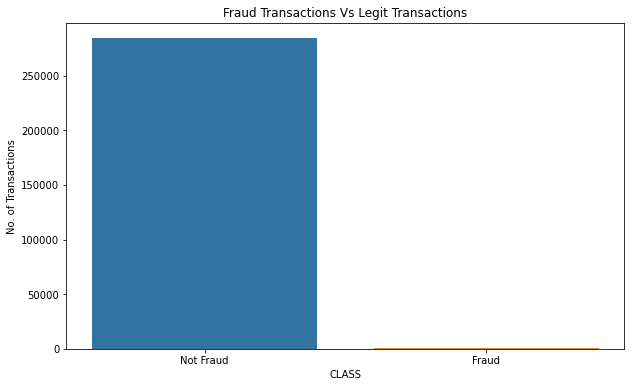

In [5]:
data = list(df["Class"].values)
ones = data.count(1)
zeros = data.count(0)
fig = plt.figure(figsize=(10,6))
sns.barplot(x=["Not Fraud", "Fraud"], y = [zeros, ones])
plt.title("Fraud Transactions Vs Legit Transactions")
plt.xlabel("CLASS")
plt.ylabel("No. of Transactions")
plt.plot()

It is clearly visible that there is a great imbalance in the data where we have extremely low fraud transactions and too many legit ones so to tackle this issue we will have to use techniques like undersapling the data while traning our model.

### Fixing Data Set Imbalance:
Now the next step will be data preparation for model fitting and testing. In our data as discussed above there is a lot of imbalance in the the Legit and the Fraud Transactions so we will do some oversampling or undersampling of data. As our Data set is not very huge we will use oversampling which will prevent the loss of any kind of valuable data. We will keep the fraud transactions and the legit ones in ratio of about 1:1 which will make it perfectly balanced. 

To do so we will take help of the imblearn library in python.

In [6]:
over_sampler = SMOTE(sampling_strategy="minority")
X = df.iloc[:, :30]
Y = df.iloc[:, 30]

X_oversampled, Y_oversampled = over_sampler.fit_resample(X, Y)
counter = 0
o_df = pd.DataFrame()
for i in list(df.columns)[:30]:
    o_df[i] = X_oversampled[i]
    counter += 1
    
o_df["Class"] = Y_oversampled
df = o_df.copy()
Counter(Y_oversampled)

Counter({0: 284315, 1: 284315})

**Now let us check for the data distribution for the other attributes as well:**

We want the distribution tu be Gaussian if not then we will apply data transformation tecniques to convert it into a Gaussian curve.

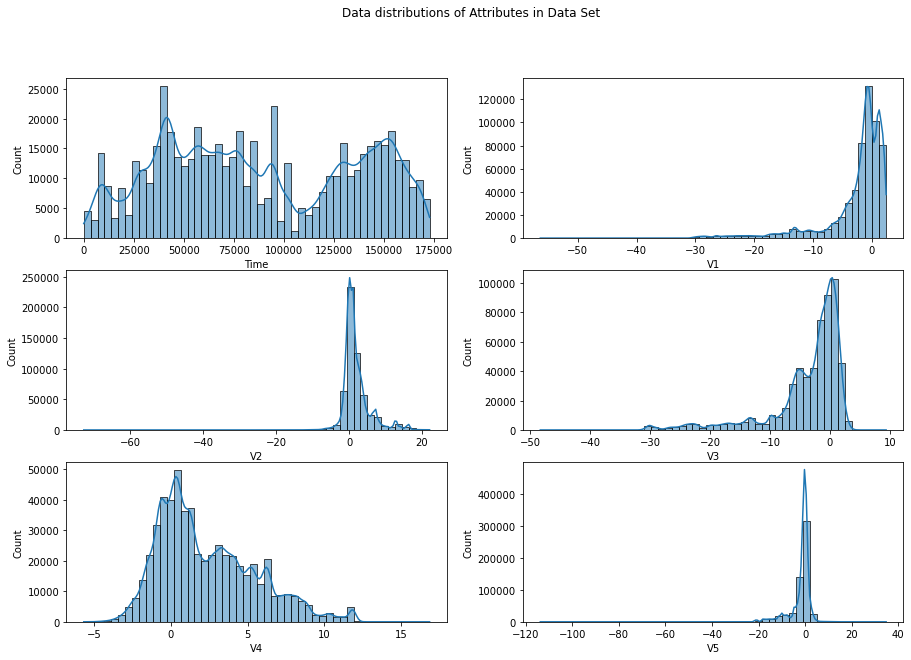

In [7]:
columns = list(df.columns)

def data_distribution(columns, bins = 50):
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle("Data distributions of Attributes in Data Set")
    counter = 1
    for i in columns:
        plt.subplot(3,2, counter)
        sns.histplot(df[i], bins = bins, kde = True)
        counter += 1
        
data_distribution(columns[:6])

**In the graphs above it is visible that the distribution of Time, V1, V3, V4 is not gaussian so we will have to do transformation of these columns**
1. Time = Not Smooth Gaussian
2. V1 = Not Smooth Gaussian
3. V3 = Left Skewed
4. V4 = Right Skewed

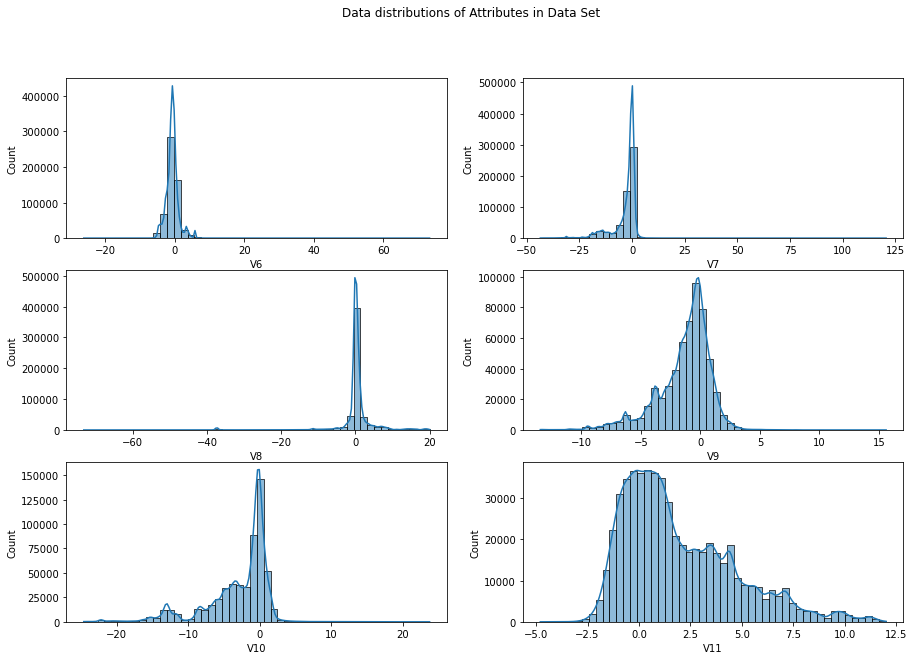

In [8]:
data_distribution(columns[6:12])

**Some of the graphs above show normal Gaussian Distribution which means no transformation is required for those but V7, V10, V11 need transformation**
1. V7 = Left Skewed
2. V10 = Left Skewed
3. V11 = Right Skewed

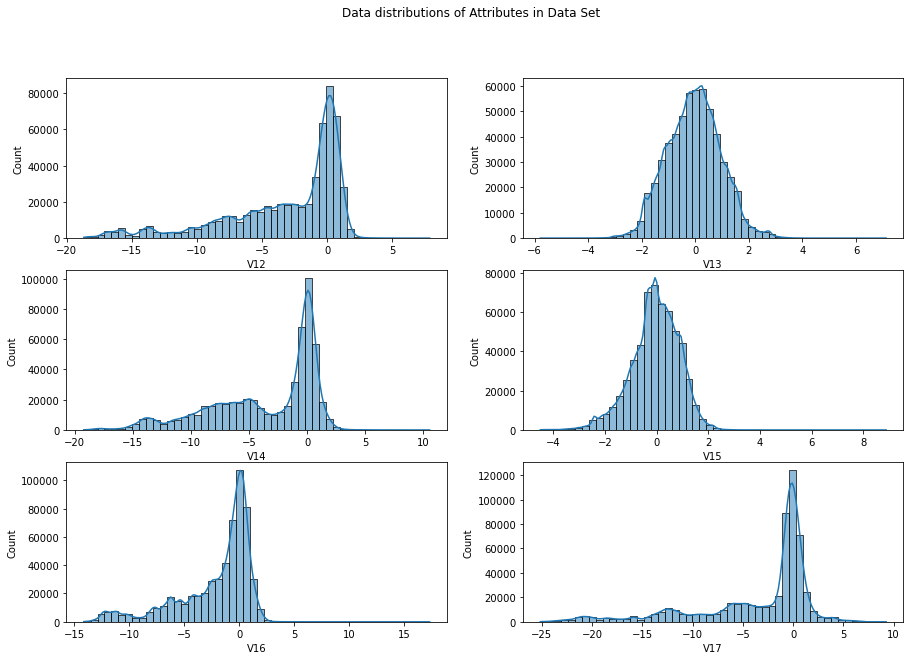

In [9]:
data_distribution(columns[12:18])

**Most of the graphs above do not show normal Gaussian Distribution which means transformation is required**
1. V12 = Left Skewed
2. V14 = Left Skewed
3. V16 = Left Skewed
4. V17 = Left Skewed

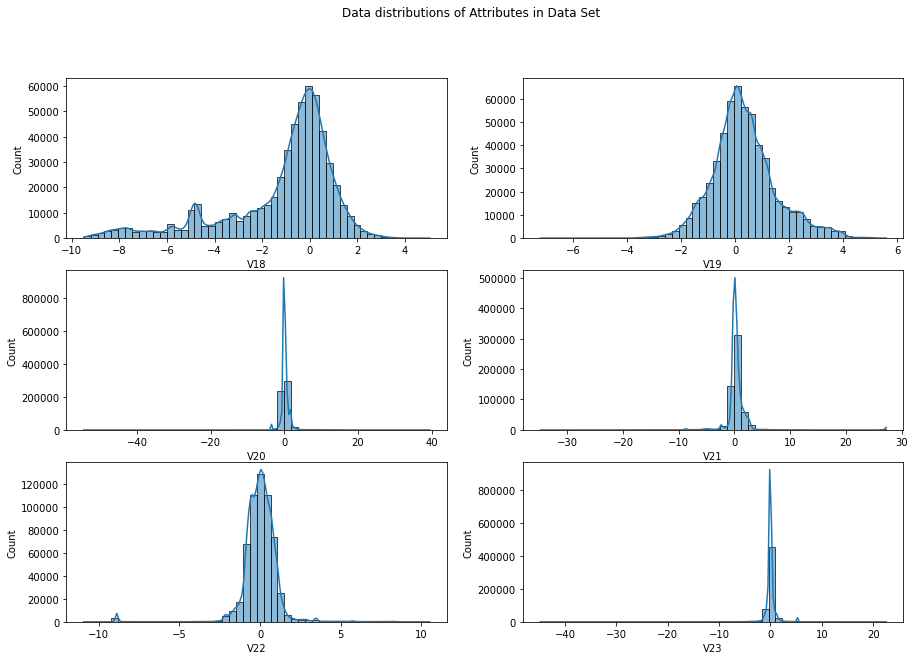

In [10]:
data_distribution(columns[18:24])

**Most of the graphs above show normal Gaussian Distribution except V18 which means no transformation is required for most of the columns**
1. V18 = Left Skewed

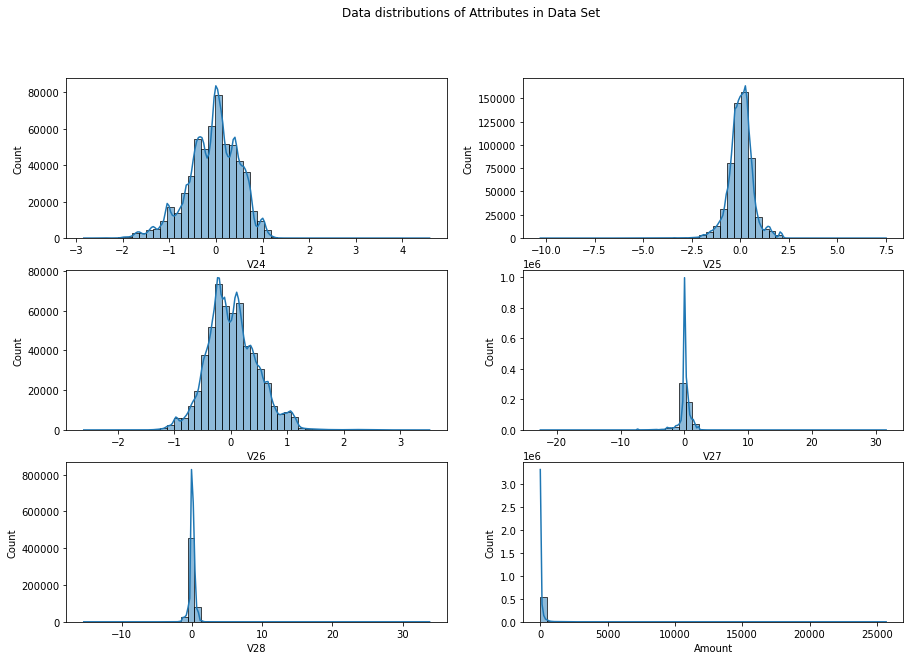

In [11]:
data_distribution(columns[24:30])

**In the graph above it is seen that the Amount variable has left skewness in the Amount data and it is seen that V24 has a Gaussian Distribution but doesn't show a smooth curve so we will have to transform the data.**
1. V24 = Not Smooth Gaussian

### Transforming the Data:

For transforming the data we will use the Power Transformer from sklearn. The variables to be transformed are:
1. Time
2. V1
3. V3
4. V4
5. V7
6. V10
7. V11
8. V12
9. V14
10. V16
11. V17
12. V18
13. V24

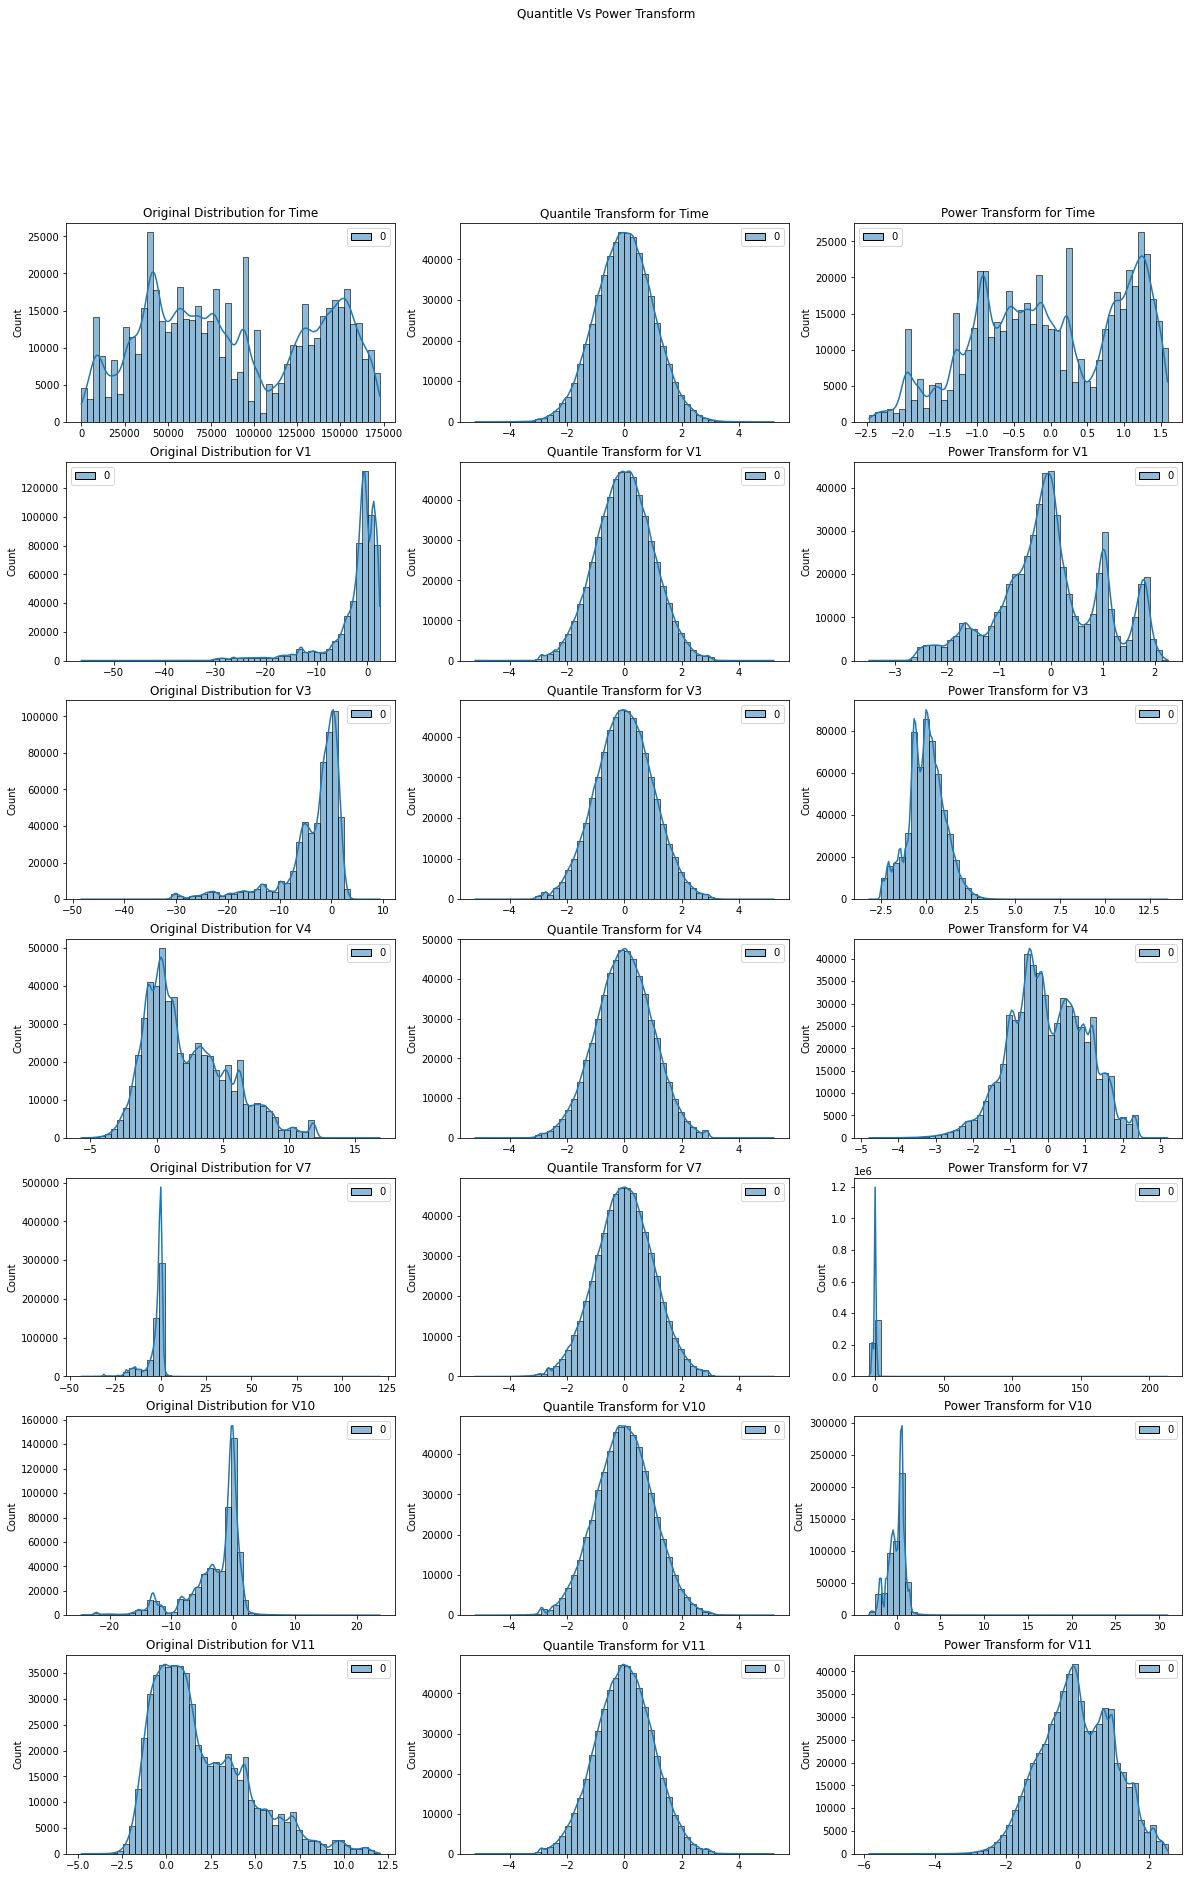

In [8]:
cols1 = ["Time", "V1", "V3", "V4", "V7", "V10", "V11"]
cols2 = ["V12", "V14", "V16", "V17", "V18", "V19", "V24"]

def check_best_transformer(columns):
    pt = PowerTransformer()
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    fig = plt.figure(figsize=(20,30))
    plt.suptitle("Quantitle Vs Power Transform")
    j = 1
    for i in columns:
        array = np.array(df[i]).reshape(-1, 1)
        y = pt.fit_transform(array)
        x = qt.fit_transform(array)
        plt.subplot(7,3,j)
        sns.histplot(array, bins = 50, kde = True)
        plt.title(f"Original Distribution for {i}")
        plt.subplot(7,3,j+1)
        sns.histplot(x, bins = 50, kde = True)
        plt.title(f"Quantile Transform for {i}")
        plt.subplot(7,3,j+2)
        sns.histplot(y, bins = 50, kde = True)
        plt.title(f"Power Transform for {i}")
        j += 3

check_best_transformer(cols1)

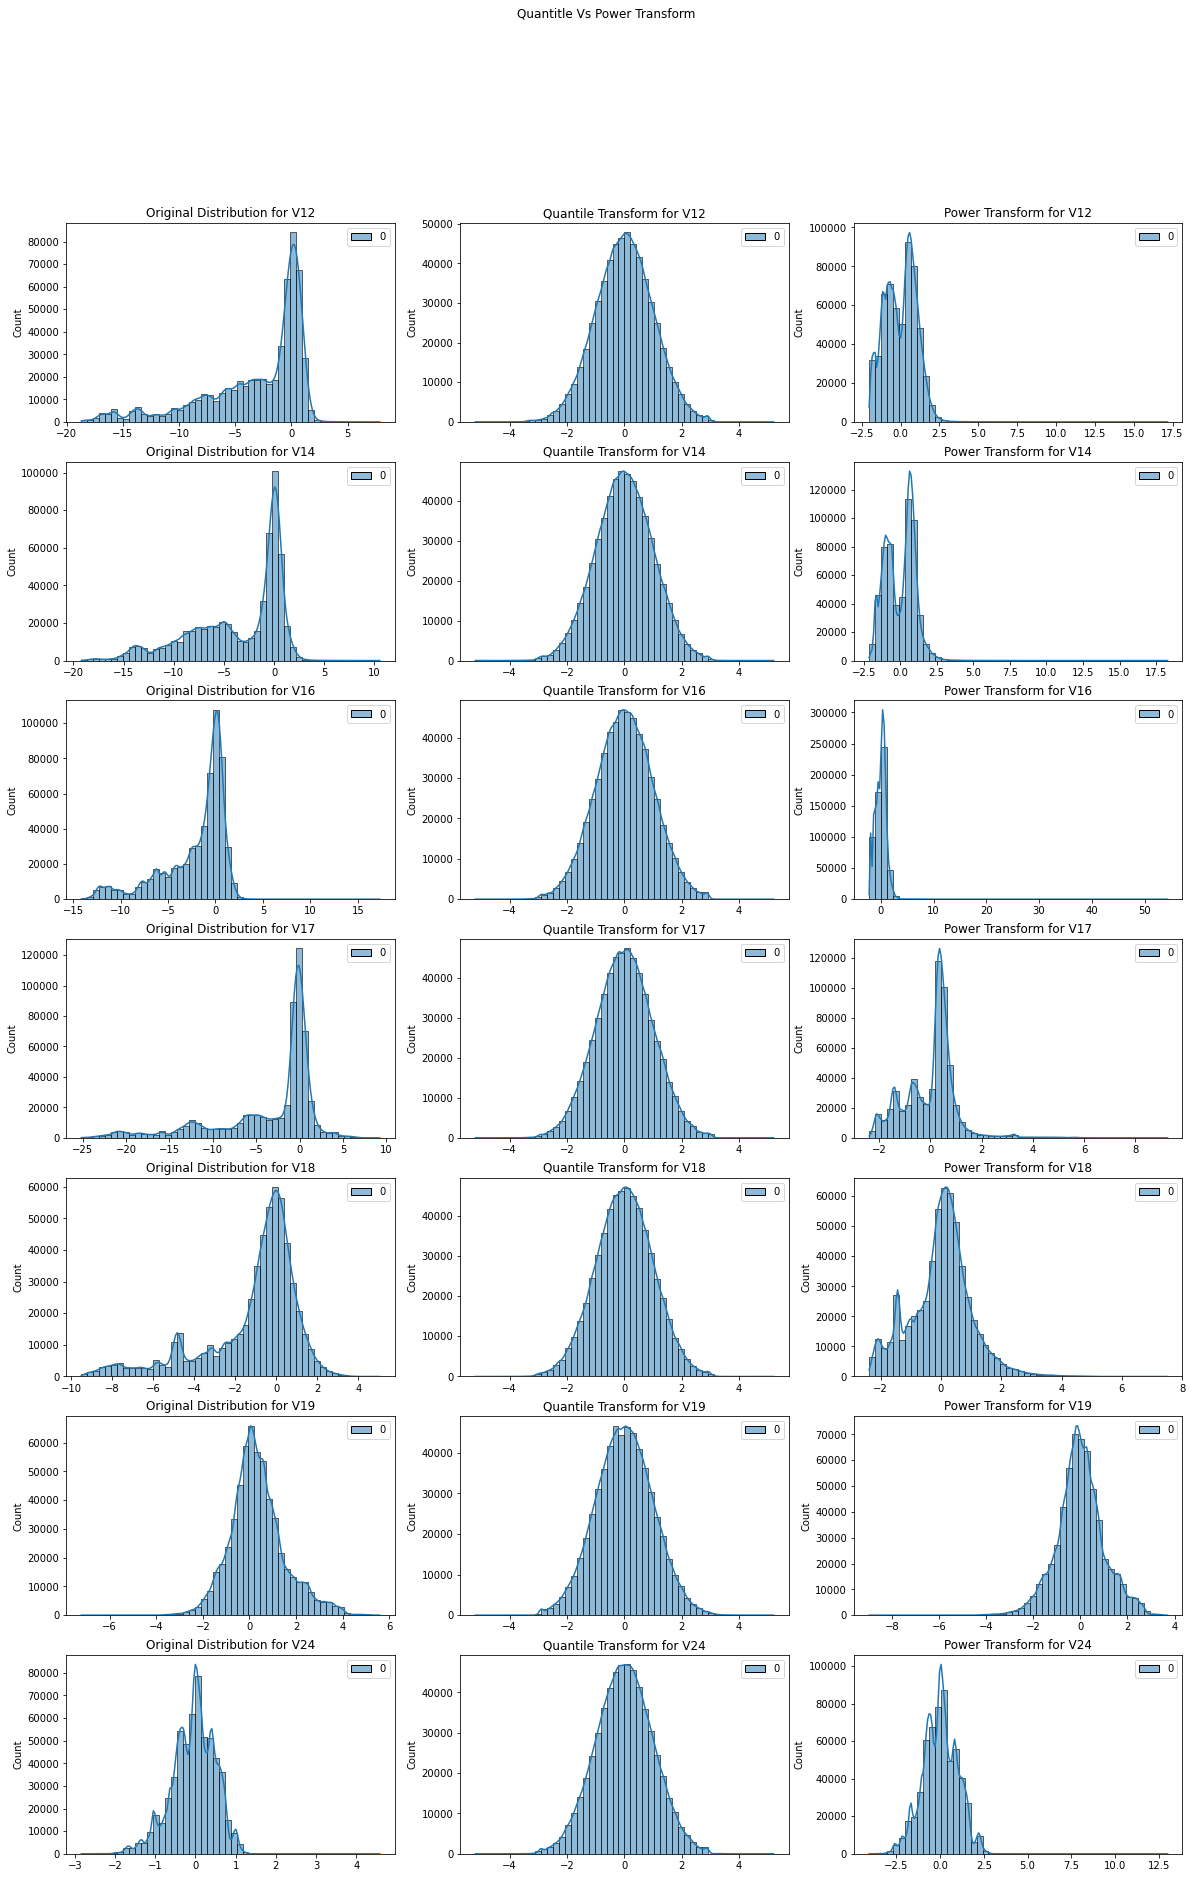

In [9]:
check_best_transformer(cols2)

**It is clearly seen from the graphs above that Quantile Transformer works a better job at transforming the data into Gaussian Distribution. So we will apply the Quantile Tranformer on our data.**

In [10]:
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
cols = cols1 + cols2
for i in cols:
    df[i] = qt.fit_transform(np.array(df[i]).reshape(-1,1))
    print(f"{i} transformation Successful!")


Time transformation Successful!
V1 transformation Successful!
V3 transformation Successful!
V4 transformation Successful!
V7 transformation Successful!
V10 transformation Successful!
V11 transformation Successful!
V12 transformation Successful!
V14 transformation Successful!
V16 transformation Successful!
V17 transformation Successful!
V18 transformation Successful!
V19 transformation Successful!
V24 transformation Successful!


### Correlation Graph:

Now we will check the correlation between independent variables and the target variables. To do this we will use the Pearson Correlation. the Pearson Correalation Coefficient ranges from (-1 to 1) where -1 means that the data is negatively correlated, 1 means that the data is positively correlated and 0 means that there is no correlation between the variables.

[]

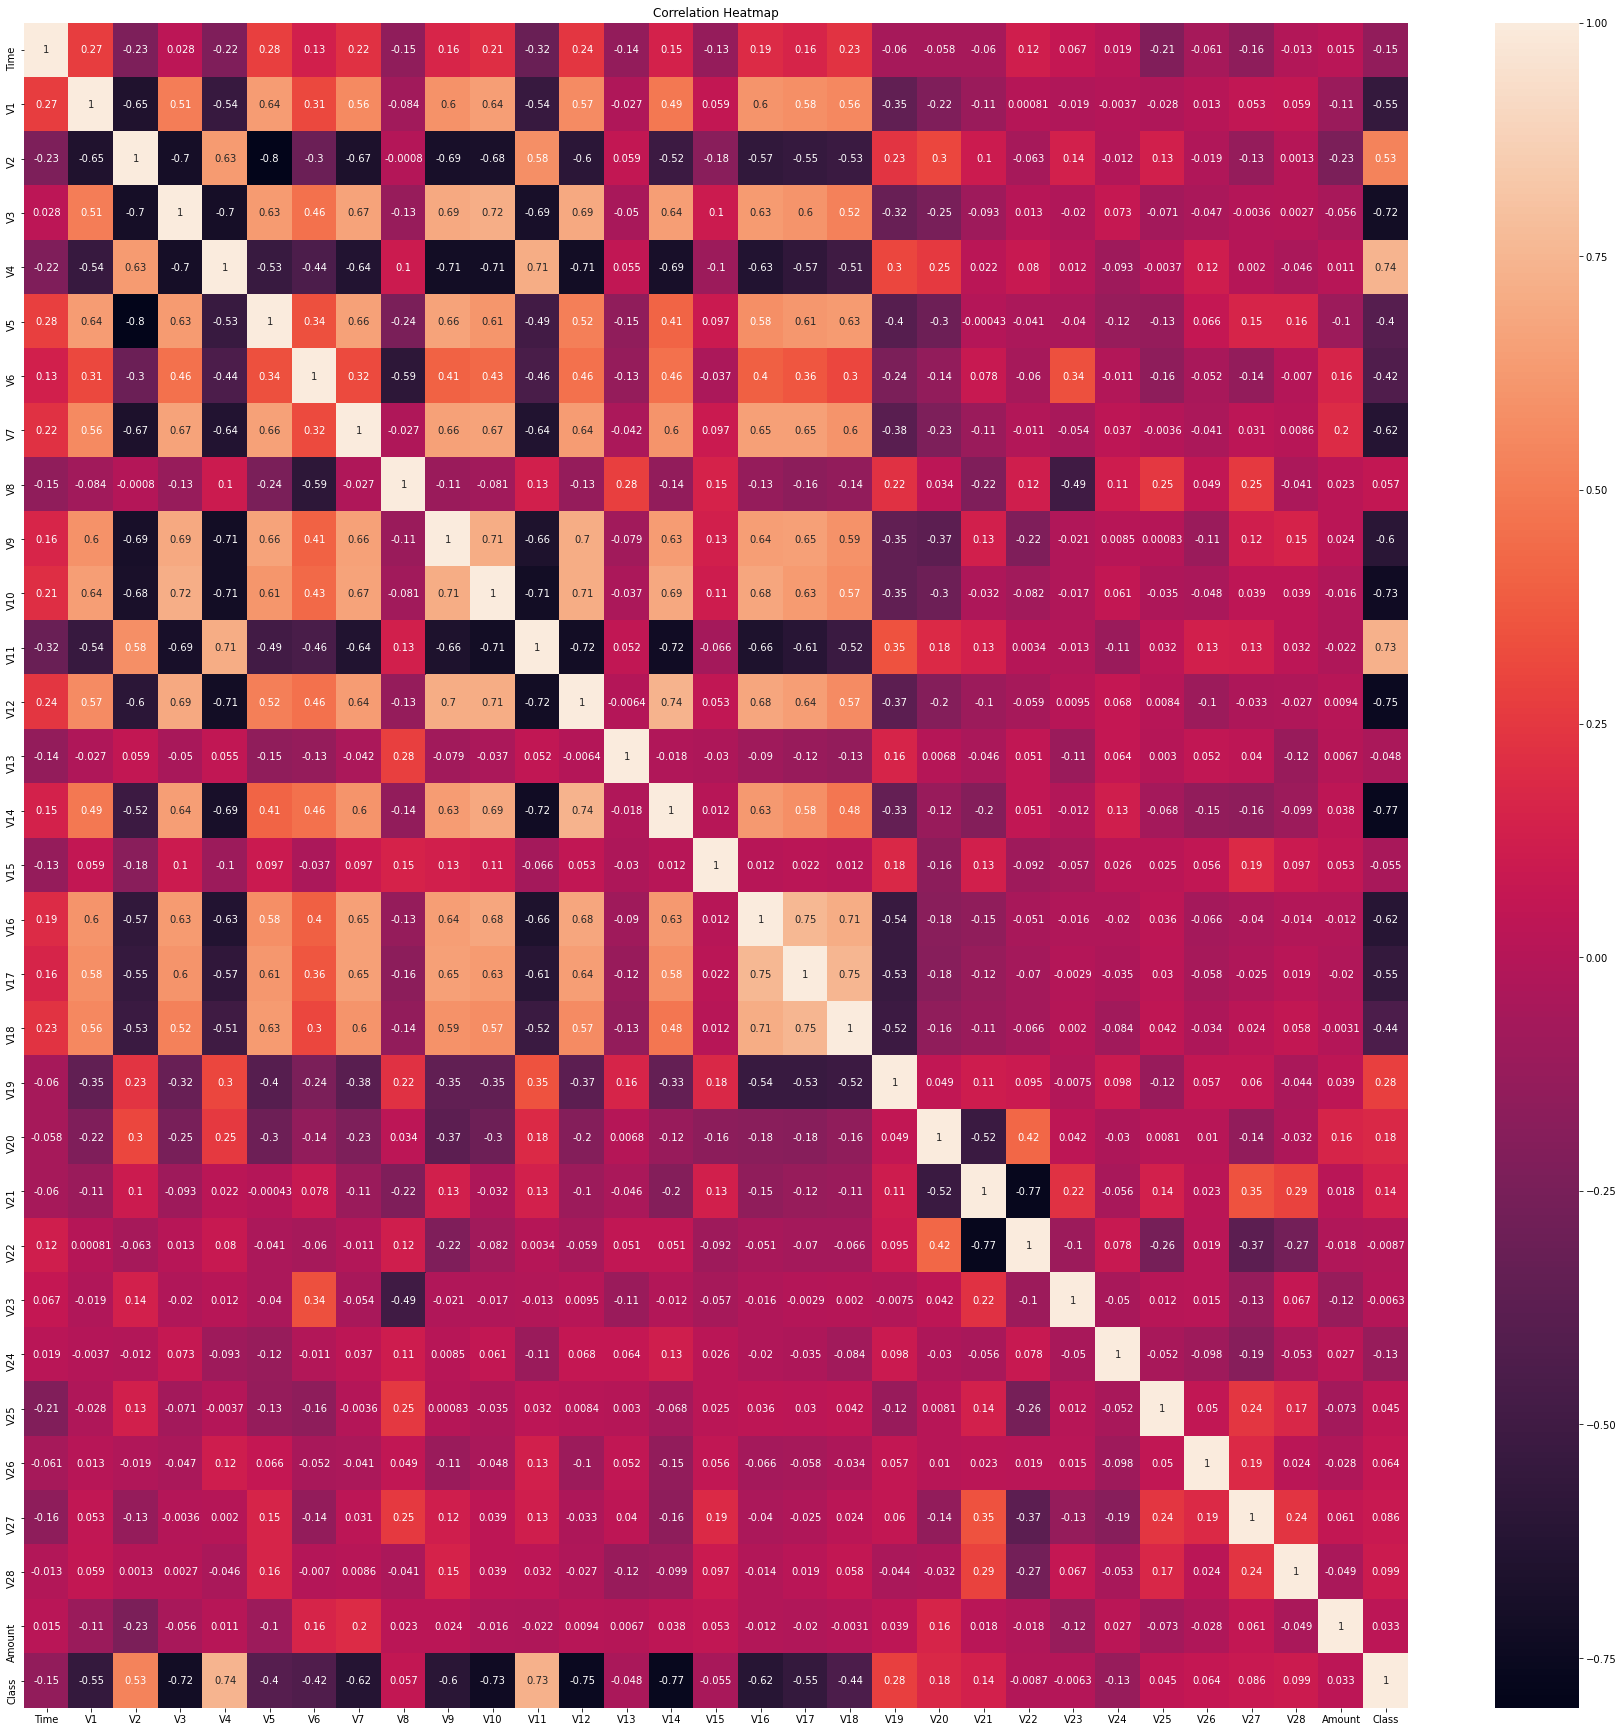

In [15]:
figure = plt.figure(figsize=(31, 31))
sns.heatmap(df.corr(), annot = True)
plt.title("Correlation Heatmap")
plt.plot()

**From the heatmap above we can see that there is a significant relation between some of the the independent variables so we might have to drop some columns from our dataset. We will keep the threshold at 0.7 and check for correlation between the columns.**

In [16]:
corr = df.corr()
pairs = []
for i in list(corr.columns)[:30]:
    for j in list(corr.columns)[:30]:
        if abs(corr.loc[i,j])>0.7 and corr.loc[i,j] != 1:
            pairs.append([i, j])
            if [i, j] not in pairs or [j, i] not in pairs:
                print(i, ' ',j ,' ', corr.loc[i,j])

V2   V3   -0.7044128627401617
V2   V5   -0.8033043752075288
V3   V4   -0.7008028373559184
V3   V10   0.7155903351529814
V4   V9   -0.7140978442680675
V4   V10   -0.7126617128348386
V4   V11   0.7090497960976518
V4   V12   -0.7121270254942282
V9   V10   0.7070971205157723
V9   V12   0.7045309516209199
V10   V11   -0.7142826826314921
V10   V12   0.7075027128692645
V11   V12   -0.7169175478031691
V11   V14   -0.7248489532048634
V12   V14   0.735984652014104
V16   V17   0.7539692030914779
V16   V18   0.7085857980366862
V17   V18   0.7466043057700975
V21   V22   -0.7727242818826672


From the above results we can observe that:
1. V2 and V5 show strong correlation so we will drop the V5 Column.
2. V12 and V11 are highly correlated with V14 and thus can will have quite similar effect on the target variable so we will drop th column V14.
3. V16 V17 and V18 show a significant correlation so in this case we will drop the V17 column.
4. V21 and V22 also show high correlation so we will drop the V22 column.

In [11]:
df.drop(columns=["V5", "V14", "V17", "V22"], inplace = True)
df.shape

(568630, 27)

### Scatter Plots:
We will plot a scatter plot to check if there are any visible clusters in our data which can indicate if we can apply clustering on our data set.

[]

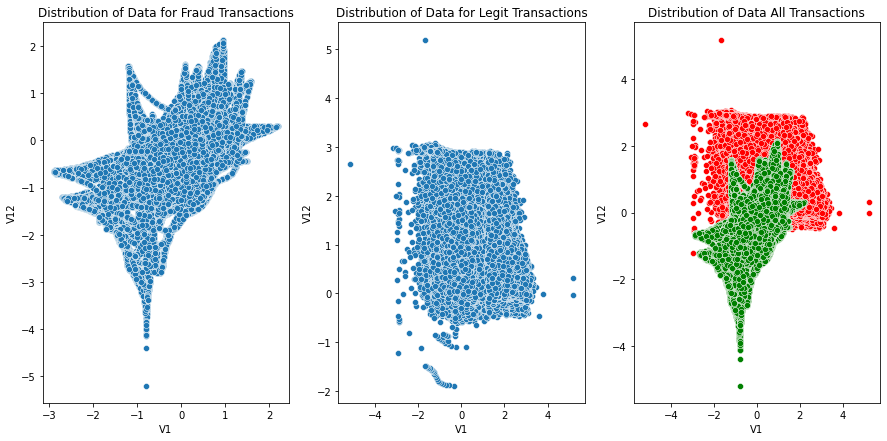

In [18]:
fig = plt.figure(figsize=(15,7))
#print(df[df["Class"]==1].shape)
plt.subplot(1,3,1)
sns.scatterplot(x = df[df["Class"]==1]["V1"], y = df[df["Class"]==1]["V12"])
plt.title("Distribution of Data for Fraud Transactions")
plt.plot()
plt.subplot(1,3,2)
sns.scatterplot(x = df[df["Class"]==0]["V1"], y = df[df["Class"]==0]["V12"])
plt.title("Distribution of Data for Legit Transactions")
plt.plot()
plt.subplot(1,3,3)
sns.scatterplot(x = df[df["Class"]==0]["V1"], y = df[df["Class"]==0]["V12"], color = "red")
sns.scatterplot(x = df[df["Class"]==1]["V1"], y = df[df["Class"]==1]["V12"], color ="green")
plt.title("Distribution of Data All Transactions")
plt.plot()

There are no visible clusters in our data. It is visible that both the transactions fraud and legit are overlapping and don't show any significant distinguishable clusters. 

### Stratified K-Fold Cross Validation:

Now to observe the performance of our models we will use the StrafiedKFold from sklearn.model_selection for this task we will split our data set into 10 folds for trainng and testing data.

The models that we will test are:

1. Random Forest
2. Logistic Regression
3. Naive Bayes
4. Stochastic Gradient Descent Classifier
5. XGBoost Classifier

In [16]:
X = df.iloc[:, :26].values
Y = df.iloc[:, 26].values

def classification_evaluation(classifier, X, Y, classifier_name, columns):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    accuracy_arr = np.zeros(shape=(1,10))
    f1_score_arr = np.zeros(shape=(1,10))
    precision_arr = np.zeros(shape=(1,10))
    recall_arr = np.zeros(shape=(1,10))
    feature_importance_arr = np.zeros(shape=(1,26))
    time_arr = []
    

    cv = StratifiedKFold(n_splits=10)
    fig, ax = plt.subplots(figsize=(15, 10))
    start_time = time.time()
    for i, (train, test) in enumerate(cv.split(X, Y)):
        itr_start_time = time.time()
        classifier.fit(X[train], Y[train])
        itr_end_time = time.time()
        viz = plot_roc_curve(classifier, X[test], Y[test],
                             name=f'ROC fold {i}',
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        try:
            feature_importance_arr += classifier.feature_importances_
        except:
            try:
                feature_importance_arr += np.array([abs(i) for i in classifier.coef_[0]])
            except:
                feature_importance_arr += np.array([abs(i) for i in permutation_importance(classifier, X[test], Y[test]).importances_mean])
            
        
        predict = classifier.predict(X[test])
        accuracy = classifier.score(X[test], Y[test])
        accuracy_arr[0, i] = accuracy
        f1 = f1_score(predict, Y[test])
        f1_score_arr[0, i] = f1
        precision = precision_score(predict, Y[test])
        precision_arr[0, i] = precision
        recall = recall_score(predict, Y[test])
        recall_arr[0, i] = recall
        train, test = train, test
        time_arr.append(itr_end_time-itr_start_time)
        print(f"Fold-{i}:  accuracy: {accuracy}  f1-score: {f1}  precision: {precision}  recall: {recall}  time: {itr_end_time-itr_start_time}")
    end_time = time.time()
    
    print()
    print(f"Classification Report for {classifier_name}")
    print("Average Accuracy :", np.mean(accuracy_arr))
    print("Average F1-Score :", np.mean(f1_score_arr))
    print("Average Precision :", np.mean(precision_arr))
    print("Average Recall :", np.mean(recall_arr))
    print("Total Time :", end_time - start_time)
    
    fig = plt.figure(figsize=(15, 10))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"Receiver Operating Characteristic for {classifier_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    feature_importance_arr /= 10
    
    fig = plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    feature_imp = pd.Series(feature_importance_arr[0], index = columns[:26])
    feature_imp.nlargest(10).plot(kind = 'bar')
    plt.title(f"Feature Importance of {classifier_name}")
    
    
    plt.subplot(1,2,2)
    plt.plot(time_arr, 'go-', color="darkblue")
    plt.plot([max(time_arr) for i in range(10)], color='lightcoral', label='UL')
    plt.plot([min(time_arr) for i in range(10)], color='lightgreen', label='LL')
    plt.title("Training time for every iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Time in sec.")
    plt.legend(loc="upper right")
    
    plt.show()
    
    return np.mean(accuracy_arr), np.mean(f1_score_arr), np.mean(precision_arr), np.mean(recall_arr), mean_auc

Fold-0:  accuracy: 0.9311503086365475  f1-score: 0.9331945463542822  precision: 0.9617670852238753  recall: 0.9062707145697998  time: 9.141664981842041
Fold-1:  accuracy: 0.9747814923588274  f1-score: 0.974409308301806  precision: 0.9602546516126763  recall: 0.9889875022640826  time: 7.230651140213013
Fold-2:  accuracy: 0.9739901165960291  f1-score: 0.9736199054668688  precision: 0.9599732686152439  recall: 0.9876601288268075  time: 9.29913878440857
Fold-3:  accuracy: 0.9740252888521534  f1-score: 0.9736602764155149  precision: 0.9601843058633182  recall: 0.9875198958182607  time: 10.205731868743896
Fold-4:  accuracy: 0.9724425373265568  f1-score: 0.9720463100058869  precision: 0.9582849706306497  recall: 0.9862086440309853  time: 6.423281192779541
Fold-5:  accuracy: 0.9479274748078715  f1-score: 0.948749459108611  precision: 0.9639490714687676  recall: 0.9340217428347476  time: 5.720000982284546
Fold-6:  accuracy: 0.9731108101929198  f1-score: 0.9727776096284295  precision: 0.96085396

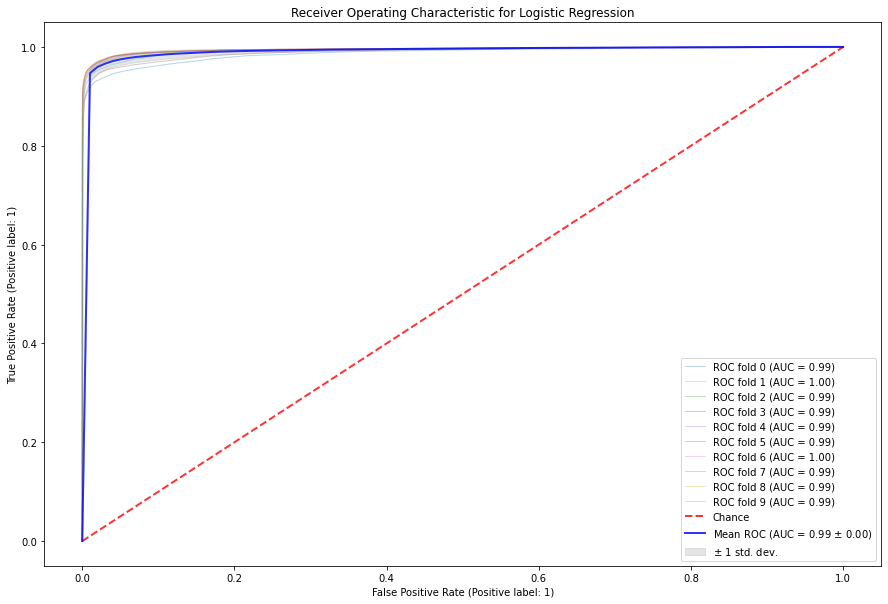

<Figure size 1080x720 with 0 Axes>

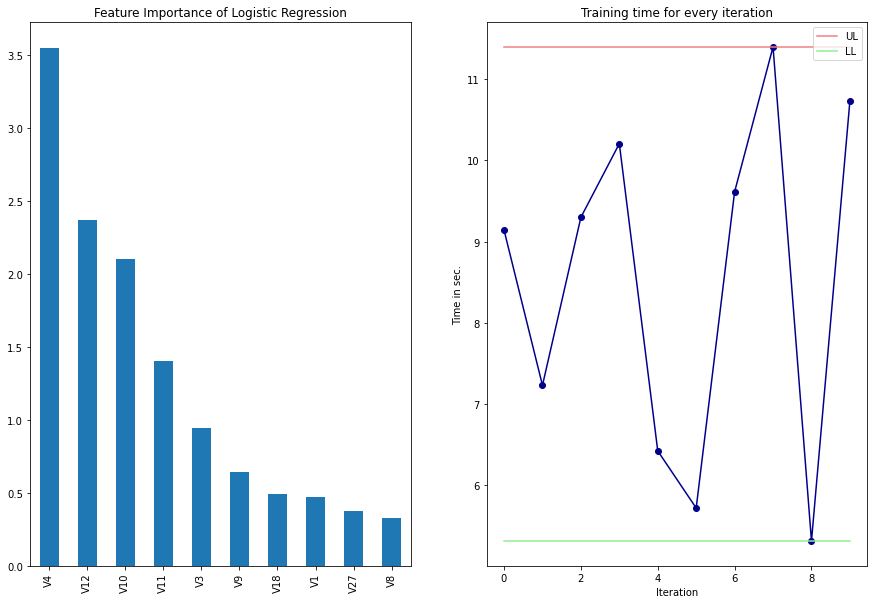

In [20]:
classifier = LogisticRegression(max_iter=1000)
lr_acc, lr_f1, lr_precision, lr_recall, lr_auc = classification_evaluation(classifier, X, Y, "Logistic Regression", list(df.columns))

Fold-0:  accuracy: 0.8945184038830171  f1-score: 0.9014005786428196  precision: 0.9643347050754458  recall: 0.8461775871115089  time: 3.6065351963043213
Fold-1:  accuracy: 0.9706311661361519  f1-score: 0.9705186597464959  precision: 0.9668319791776582  recall: 0.9742335637072479  time: 5.515480995178223
Fold-2:  accuracy: 0.9679404885426376  f1-score: 0.9679562672478951  precision: 0.9684499314128944  recall: 0.967463106113844  time: 5.256807327270508
Fold-3:  accuracy: 0.9663225647609166  f1-score: 0.9661415513004119  precision: 0.9609932819809363  recall: 0.9713452787258248  time: 3.5593011379241943
Fold-4:  accuracy: 0.9653729138455587  f1-score: 0.9651485919606351  precision: 0.9589532552495516  recall: 0.9714244993942849  time: 5.905037879943848
Fold-5:  accuracy: 0.9142324534407259  f1-score: 0.9181175601484193  precision: 0.9616629150253235  recall: 0.8783449516527997  time: 7.30206298828125
Fold-6:  accuracy: 0.9484726447777992  f1-score: 0.9464761974352417  precision: 0.911156

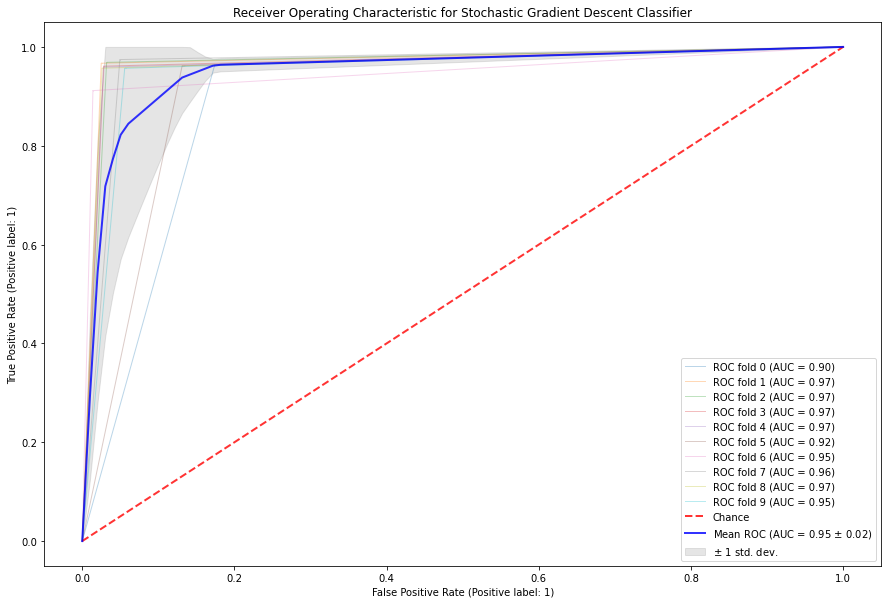

<Figure size 1080x720 with 0 Axes>

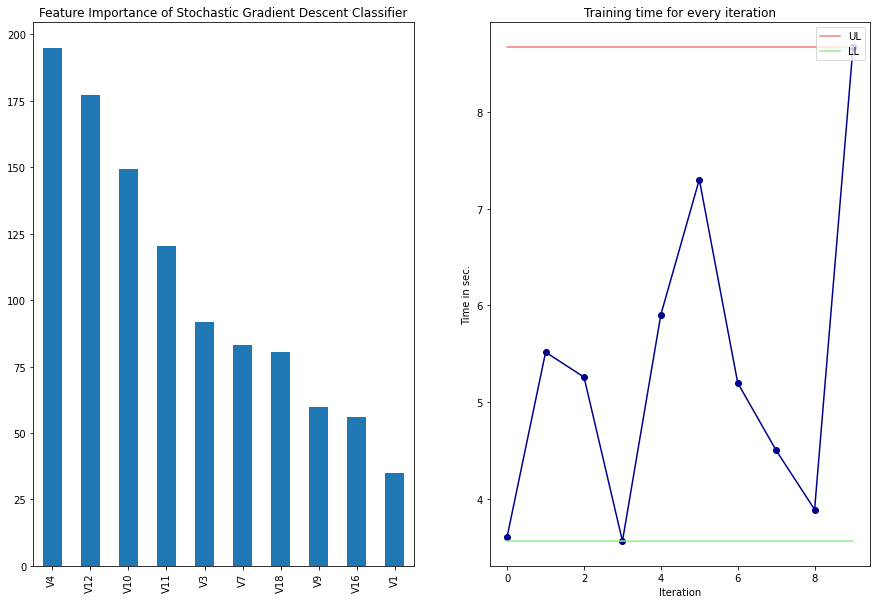

In [21]:
classifier = SGDClassifier(loss="modified_huber", penalty = "l2")
sgd_acc, sgd_f1, sgd_precision, sgd_recall, sgd_auc = classification_evaluation(classifier, X, Y, "Stochastic Gradient Descent Classifier", list(df.columns))

Fold-0:  accuracy: 0.89212669046656  f1-score: 0.8820021545090797  precision: 0.8063381520171644  recall: 0.9733367299282469  time: 0.16075801849365234
Fold-1:  accuracy: 0.8915991066246944  f1-score: 0.8805750377804472  precision: 0.7993035770813549  recall: 0.980244144416167  time: 0.1128380298614502
Fold-2:  accuracy: 0.8878180890913248  f1-score: 0.8765649490121713  precision: 0.7966656114804263  recall: 0.9742773571920165  time: 0.10905098915100098
Fold-3:  accuracy: 0.8934984084554104  f1-score: 0.8830165353113894  precision: 0.8039112236643101  recall: 0.9793889531645027  time: 0.11202311515808105
Fold-4:  accuracy: 0.891177039551202  f1-score: 0.8800682223428172  precision: 0.7985649467130949  recall: 0.9800992877185409  time: 0.11566901206970215
Fold-5:  accuracy: 0.8938677171447162  f1-score: 0.8838104772722896  precision: 0.8072945976364659  recall: 0.9763494831766557  time: 0.11019015312194824
Fold-6:  accuracy: 0.889928424458787  f1-score: 0.8790975294094923  precision: 0.

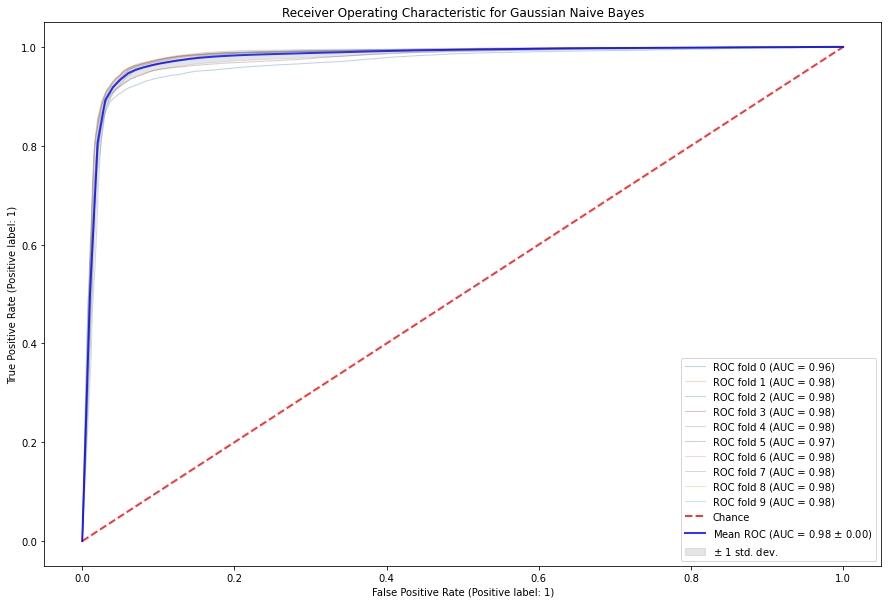

<Figure size 1080x720 with 0 Axes>

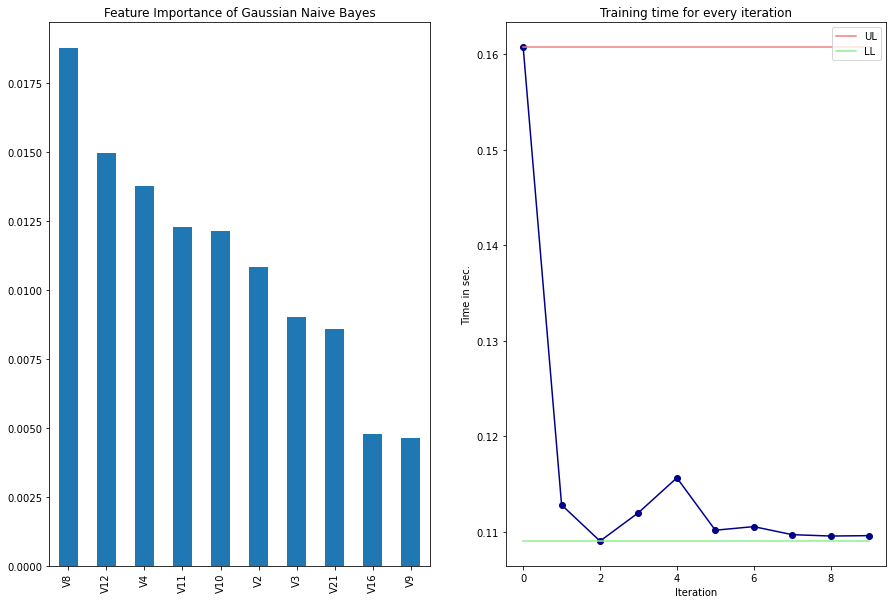

In [22]:
classifier = GaussianNB()
gn_acc, gn_f1, gn_precision, gn_recall, gn_auc = classification_evaluation(classifier, X, Y, "Gaussian Naive Bayes", list(df.columns))

Fold-0:  accuracy: 0.9834866257496087  f1-score: 0.9837540441876158  precision: 0.999964827125321  recall: 0.9680604739852902  time: 55.52685308456421
Fold-1:  accuracy: 0.9999296554877513  f1-score: 0.9999296591988183  precision: 1.0  recall: 0.9998593282925972  time: 57.50978708267212
Fold-2:  accuracy: 0.9999472416158135  f1-score: 0.9999472434713795  precision: 1.0  recall: 0.9998944925089681  time: 56.7369179725647
Fold-3:  accuracy: 0.9999648277438756  f1-score: 0.9999648283624085  precision: 1.0  recall: 0.9999296591988183  time: 56.32336902618408
Fold-4:  accuracy: 0.9998944832316269  f1-score: 0.9998944925089681  precision: 1.0  recall: 0.9997890072792489  time: 57.50444197654724
Fold-5:  accuracy: 0.9982765594499059  f1-score: 0.9982794943820225  precision: 0.9999648283624085  recall: 0.9965998317442513  time: 57.10519218444824
Fold-6:  accuracy: 0.9998944832316269  f1-score: 0.9998944962194479  precision: 1.0  recall: 0.9997890146986427  time: 57.019665002822876
Fold-7:  acc

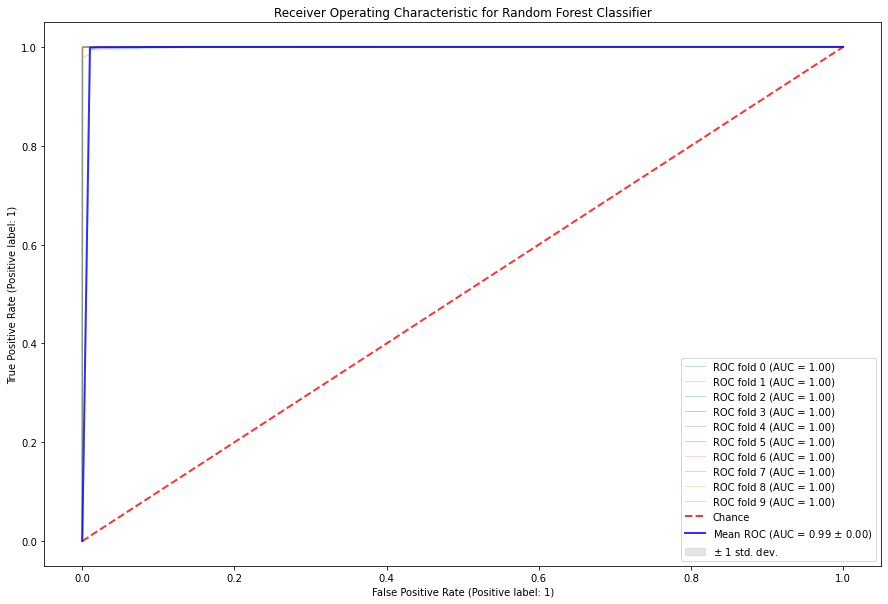

<Figure size 1080x720 with 0 Axes>

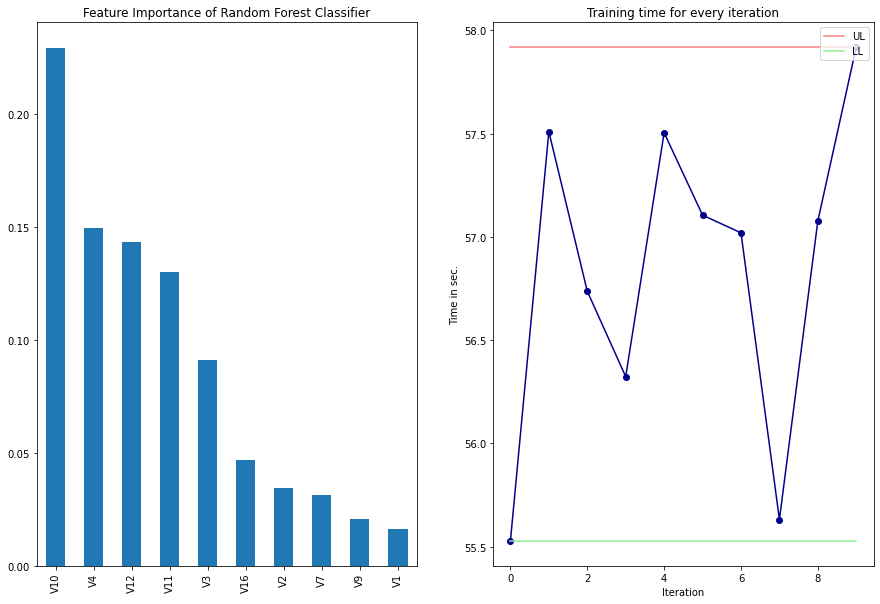

In [23]:
classifier = RandomForestClassifier(n_estimators=20, max_depth = 26)
rf_acc, rf_f1, rf_precision, rf_recall, rf_auc = classification_evaluation(classifier, X, Y, "Random Forest Classifier", list(df.columns))

Fold-0:  accuracy: 0.9416843993457961  f1-score: 0.9448931432180012  precision: 0.999929654250642  recall: 0.8955990297073371  time: 186.48045086860657
Fold-1:  accuracy: 0.9982062149376572  f1-score: 0.9982093954076259  precision: 1.0  recall: 0.9964251918830828  time: 238.77140188217163
Fold-2:  accuracy: 0.9935986493853648  f1-score: 0.9936392548841436  precision: 1.0  recall: 0.9873589164785553  time: 189.3170611858368
Fold-3:  accuracy: 0.9982413871937815  f1-score: 0.9982444436641973  precision: 1.0  recall: 0.9964950404822824  time: 186.844868183136
Fold-4:  accuracy: 0.9997010358229429  f1-score: 0.9997011199212362  precision: 1.0  recall: 0.9994024184476941  time: 188.6183590888977
Fold-5:  accuracy: 0.9765225190369836  f1-score: 0.9770614615371398  precision: 1.0  recall: 0.9551516780327208  time: 188.74641728401184
Fold-6:  accuracy: 0.9992437964933261  f1-score: 0.9992443811833343  precision: 1.0  recall: 0.9984899034240562  time: 188.45297527313232
Fold-7:  accuracy: 0.998

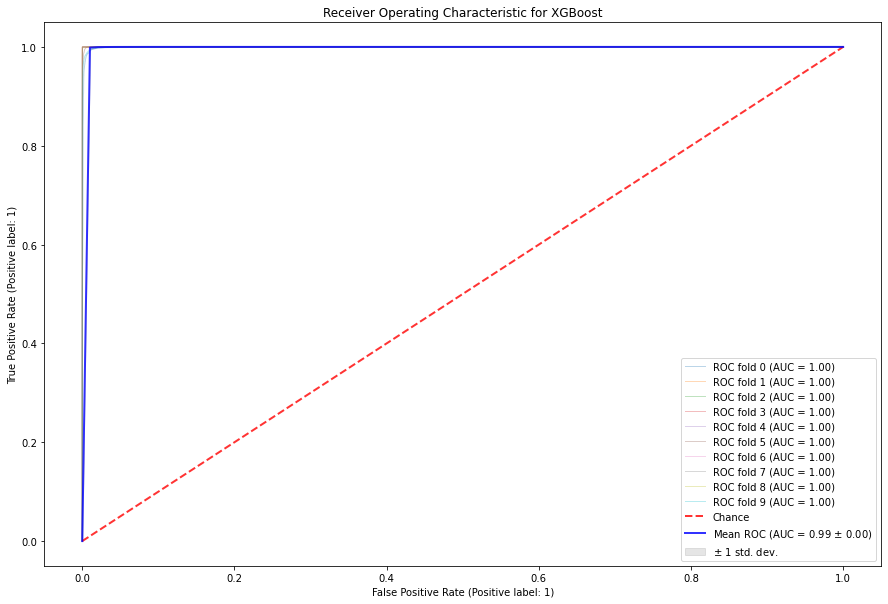

<Figure size 1080x720 with 0 Axes>

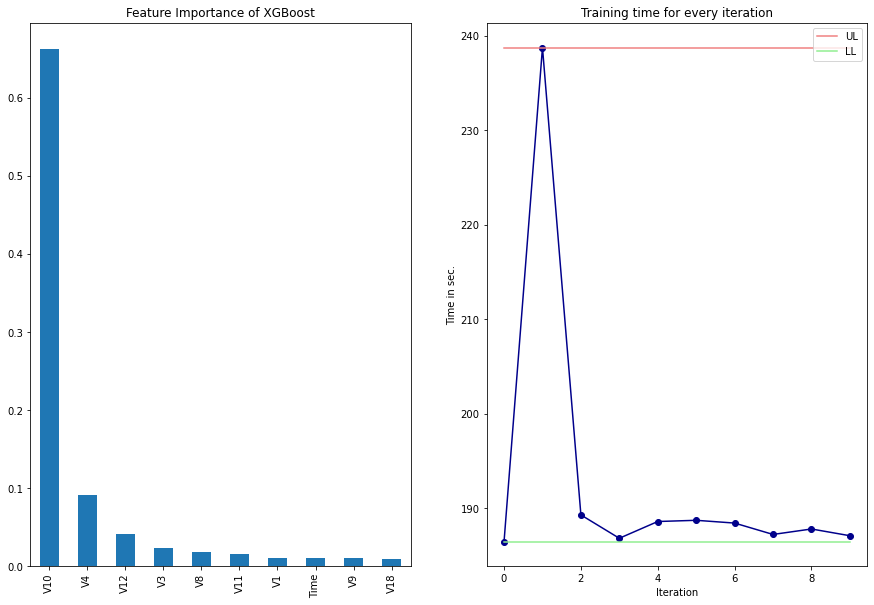

In [24]:
classifier = XGBClassifier(use_label_encoder=False, disable_default_eval_metric=1)
xg_acc, xg_f1, xg_precision, xg_recall, xg_auc = classification_evaluation(classifier, X, Y, "XGBoost", list(df.columns))

### Hybrid Model Creation:

In this hybrid model we will try to use the weighted average of the probabilities of all the models which clear the threshold and compare it with the result of individual predictions. It is believed that a hybrid model is bound to give better or more generalized results as any models having a bias will be neutralized in this process. 

Threshold:
1. Accuracy > 90
2. f1 > 90
3. auc > 90

This hybrid model will be applied for both RandomOverSampling as well as SMOTEK over sampling. This Notebook contains the results for SMOTE Oversampling.

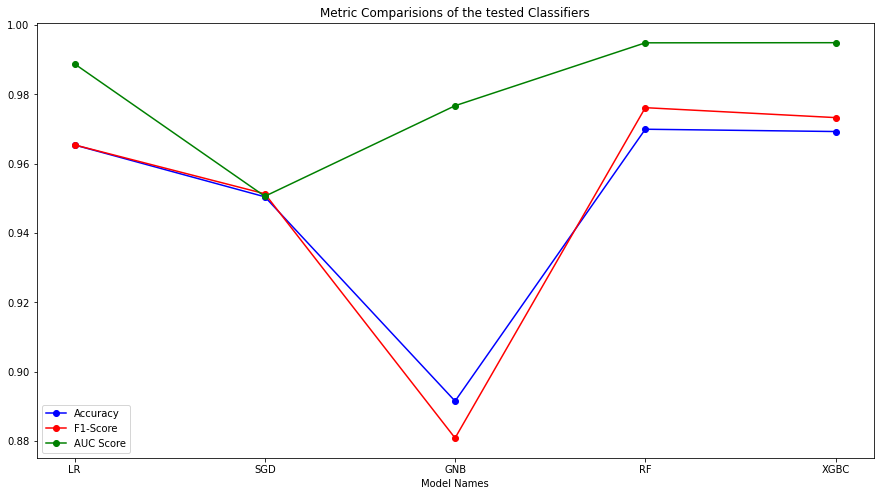

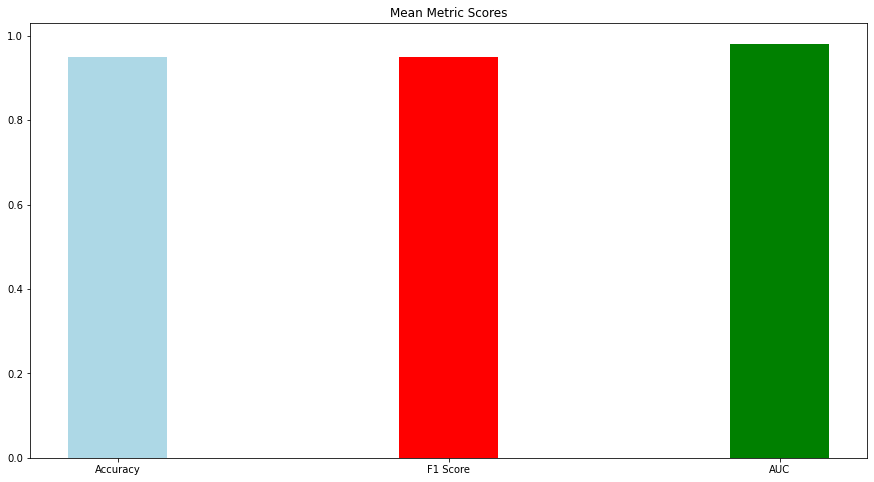

In [25]:
accuracy = [lr_acc, sgd_acc, gn_acc, rf_acc, xg_acc]
f1_scores = [lr_f1, sgd_f1, gn_f1, rf_f1, xg_f1]
auc_scores = [lr_auc, sgd_auc, gn_auc, rf_auc, xg_auc]

mean_acc = sum(accuracy)/5
mean_f1 = sum(f1_scores)/5
mean_auc = sum(auc_scores)/5

fig = plt.figure(figsize=(15,8))
plt.title("Metric Comparisions of the tested Classifiers")
plt.plot(accuracy,'go-', color="blue", label="Accuracy")
plt.plot(f1_scores,'go-', color="red", label="F1-Score")
plt.plot(auc_scores,'go-', color="green", label="AUC Score")
plt.xticks([i for i in range(5)], ["LR", "SGD", "GNB", "RF", "XGBC"])
plt.legend()
plt.xlabel('Model Names')
plt.show()

fig = plt.figure(figsize=(15,8))
plt.title("Mean Metric Scores")
plt.bar(height=[mean_acc, mean_f1, mean_auc], x = ["Accuracy", "F1 Score", "AUC"], width=.3, color=["lightblue", "red", "green"])
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
def hybrid_model_formation(clf1, clf2, clf3, clf4, clf5, X, Y, columns):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)
    
    print("Phase 1 Started")
    print("Training Models and Generating Report:")
    print("------------------------------------------------------------------------------------------------------")
    try:
        t1 = time.time()
        clf1.fit(x_train, y_train)
        clf1_acc = clf1.score(x_test, y_test)
        pred1 = clf1.predict(x_test)
        clf1_f1 = f1_score(pred1, y_test)
        clf1_pre = precision_score(pred1, y_test)
        clf1_rec = recall_score(pred1, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf1.predict_proba(x_test)[:, 1])
        clf1_auc = metrics.auc(fpr, tpr)
        feature_imp1 = pd.Series([abs(i) for i in clf1.coef_[0]], index = columns[:26])
        t1_ = time.time()
        final_t1 = t1_ - t1
        print("Model 1 Trained and Tested: ")
        print("Accuracy: ", clf1_acc)
        print("F1 Score:", clf1_f1)
        print("AUC Score: ", clf1_auc)
        print("Precision Score: ", clf1_pre)
        print("Recall Score: ", clf1_rec)
        print("Time :", final_t1)
        
        print("------------------------------------------------------------------------------------------------------")
        t2 = time.time()
        clf2.fit(x_train, y_train)
        clf2_acc = clf2.score(x_test, y_test)
        pred2 = clf2.predict(x_test)
        clf2_pre = precision_score(pred2, y_test)
        clf2_rec = recall_score(pred2, y_test)
        clf2_f1 = f1_score(pred2, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf2.predict_proba(x_test)[:, 1])
        clf2_auc = metrics.auc(fpr, tpr)
        feature_imp2 = pd.Series([abs(i) for i in clf2.coef_[0]], index = columns[:26])
        t2_ = time.time()
        final_t2 = t2_ - t2
        print("Model 2 Trained and Tested: ")
        print("Accuracy: ", clf2_acc)
        print("F1 Score:", clf2_f1)
        print("AUC Score: ", clf2_auc)
        print("Precision Score: ", clf2_pre)
        print("Recall Score: ", clf2_rec)
        print("Time :", final_t2)
        
        print("------------------------------------------------------------------------------------------------------")
        t3 = time.time()
        clf3.fit(x_train, y_train)
        clf3_acc = clf3.score(x_test, y_test)
        pred3 = clf3.predict(x_test)
        clf3_f1 = f1_score(pred3, y_test)
        clf3_pre = precision_score(pred3, y_test)
        clf3_rec = recall_score(pred3, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf3.predict_proba(x_test)[:, 1])
        clf3_auc = metrics.auc(fpr, tpr)
        feature_imp3 = pd.Series([abs(i) for i in permutation_importance(clf3, x_test, y_test).importances_mean], index = columns[:26])
        t3_ = time.time()
        final_t3 = t3_ - t3
        print("Model 3 Trained and Tested: ")
        print("Accuracy: ", clf3_acc)
        print("F1 Score:", clf3_f1)
        print("AUC Score: ", clf3_auc)
        print("Precision Score: ", clf3_pre)
        print("Recall Score: ", clf3_rec)
        print("Time :", final_t3)
        
        print("------------------------------------------------------------------------------------------------------")
        t4 = time.time()
        clf4.fit(x_train, y_train)
        clf4_acc = clf4.score(x_test, y_test)
        pred4 = clf4.predict(x_test)
        clf4_f1 = f1_score(pred4, y_test)
        clf4_pre = precision_score(pred4, y_test)
        clf4_rec = recall_score(pred4, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf4.predict_proba(x_test)[:, 1])
        clf4_auc = metrics.auc(fpr, tpr)
        feature_imp4 = pd.Series(clf4.feature_importances_, index = columns[:26])
        t4_ = time.time()
        final_t4 = t4_ - t4
        print("Model 4 Trained and Tested: ")
        print("Accuracy: ", clf4_acc)
        print("F1 Score:", clf4_f1)
        print("AUC Score: ", clf4_auc)
        print("Precision Score: ", clf4_pre)
        print("Recall Score: ", clf4_rec)
        print("Time :", final_t4)
        
        print("------------------------------------------------------------------------------------------------------")
        t5 = time.time()
        clf5.fit(x_train, y_train)
        clf5_acc = clf5.score(x_test, y_test)
        pred5 = clf5.predict(x_test)
        clf5_f1 = f1_score(pred5, y_test)
        clf5_pre = precision_score(pred5, y_test)
        clf5_rec = recall_score(pred5, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf5.predict_proba(x_test)[:, 1])
        clf5_auc = metrics.auc(fpr, tpr)
        feature_imp5 = pd.Series(clf5.feature_importances_, index = columns[:26])
        t5_ = time.time()
        final_t5 = t5_ - t5
        print("Model 5 Trained and Tested: ")
        print("Accuracy: ", clf5_acc)
        print("F1 Score:", clf5_f1)
        print("AUC Score: ", clf5_auc)
        print("Precision Score: ", clf5_pre)
        print("Recall Score: ", clf5_rec)
        print("Time :", final_t5)
        print("------------------------------------------------------------------------------------------------------")
        print("Process Successfully completed without any errors....")
    except:
        print("Error Occured during model training and evaluation....")
        return "Error!!"
    
    print()
    print("Phase 2 Started")
    print("The slelection process has started....")
    all_classifiers = [clf1, clf2, clf3, clf4, clf5]
    all_classifiers_names = ["clf1", "clf2", "clf3", "clf4", "clf5"]
    selected_classifiers = [0 for i in range(5)]
    classifiers = {"clf1":clf1, "clf2":clf2, "clf3":clf3, "clf4":clf4, "clf5":clf5}
    accuracys = [clf1_acc, clf2_acc, clf3_acc, clf4_acc, clf5_acc]
    f1_scores = [clf1_f1, clf2_f1, clf3_f1, clf4_f1, clf5_f1]
    auc_scores = [clf1_auc, clf2_auc, clf3_auc, clf4_auc, clf5_auc]
    precision_scores = [clf1_pre, clf2_pre, clf3_pre, clf4_pre, clf5_pre]
    recall_scores = [clf1_rec, clf2_rec, clf3_rec, clf4_rec, clf5_rec]
    train_time = [final_t1, final_t2, final_t3, final_t4, final_t5]
    f_imp = [feature_imp1, feature_imp2, feature_imp3, feature_imp4, feature_imp5]
    
    fig = plt.figure(figsize=(15, 10))
    for o in range(5):
        plt.subplot(3,2,o+1)
        f_imp[o].nlargest(10).plot(kind = 'barh')
        plt.title(f"Feature Importance of {all_classifiers_names[o]}")
    
    
    fig = plt.figure(figsize=(15, 8))
    plt.plot([i*100 for i in accuracys], 'go-', color='lightblue', label='Accuracy')
    plt.plot([i*100 for i in f1_scores], 'go-', color='red', label='F1-Score')
    plt.plot([i*100 for i in auc_scores], 'go-', color='green', label='AUC-Score')
    plt.plot(train_time, 'go-', color='darkblue', label='Train Time(sec)')
    plt.title('Model Performance')
    plt.legend()
    plt.xticks([i for i in range(5)], all_classifiers_names)
    plt.xlabel('Model Names')
    plt.show()
    
    for i in range(5):
        if accuracys[i] >= .90 and f1_scores[i] >= .90 and auc_scores[i] >= .90 and precision_scores[i] >= 0.9 and recall_scores[i] >= 0.9:
            selected_classifiers[i] = 1
            
    for j in range(5):
        if not selected_classifiers[j]:
            all_classifiers[j] = None
            all_classifiers_names[j] = None
            f1_scores[j] = None
            
    all_classifiers = [i for i in all_classifiers if i != None]
    all_classifiers_names = [i for i in all_classifiers_names if i != None]
    f1_scores = [i for i in f1_scores if i != None]
    
    print("The selected classifiers are: ")
    for i in range(len(all_classifiers)):
        print(f"{i+1}. {all_classifiers_names[i]}")
    
    print()
    print("Phase 3 Started")
    # Final testing with formula:
    numerator = []
    denominator = sum([i for i in f1_scores])
    for i in range(len(all_classifiers)):
        proba = all_classifiers[i].predict_proba(x_test)[:, 1]
        # print(proba)
        final_num = np.array([x*f1_scores[i] for x in proba])
        numerator.append(final_num)
        
    numerator_val = np.zeros(shape=y_test.shape)
    for j in range(len(numerator)):
        numerator_val += numerator[j]
        
    numerator_val /= denominator
    
    for i in range(len(numerator_val)):
        if numerator_val[i] > 0.5:
            numerator_val[i] = 1
        else:
            numerator_val[i] = 0
    
    print("The final model is ready and has been evaluated the results are as following:")
    print("Accuracy :", metrics.accuracy_score(numerator_val, y_test))
    print("F1 Score :", f1_score(numerator_val, y_test))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, numerator_val)
    print("AUC Score: ", metrics.auc(fpr, tpr))
    print("Average Precision :", precision_score(numerator_val, y_test))
    print("Average Recall :", recall_score(numerator_val, y_test))
    mat = confusion_matrix(numerator_val, y_test)
    x = [mat[0][0], mat[1][0]]
    y = [mat[0][1], mat[1][1]]
    df = pd.DataFrame({"Fraud": x, "Not Fraud": y})
    df.set_index(pd.Index(["Fraud", "Not Fraud"]), inplace = True)
    sns.heatmap(df, annot=True)
    print("Compilation successful!")

Phase 1 Started
Training Models and Generating Report:
------------------------------------------------------------------------------------------------------
Model 1 Trained and Tested: 
Accuracy:  0.9710971985297997
F1 Score: 0.9707163665844076
AUC Score:  0.9941454844020381
Precision Score:  0.9591549295774648
Recall Score:  0.9825599220877594
Time : 7.319999933242798
------------------------------------------------------------------------------------------------------
Model 2 Trained and Tested: 
Accuracy:  0.9623656859469251
F1 Score: 0.9620923600162967
AUC Score:  0.9625759128913591
Precision Score:  0.9562147887323944
Recall Score:  0.9680426335864257
Time : 4.574825763702393
------------------------------------------------------------------------------------------------------
Model 3 Trained and Tested: 
Accuracy:  0.8906142834532121
F1 Score: 0.8796742305534598
AUC Score:  0.9777409178483754
Precision Score:  0.800580985915493
Recall Score:  0.9761087021852058
Time : 3.53751182

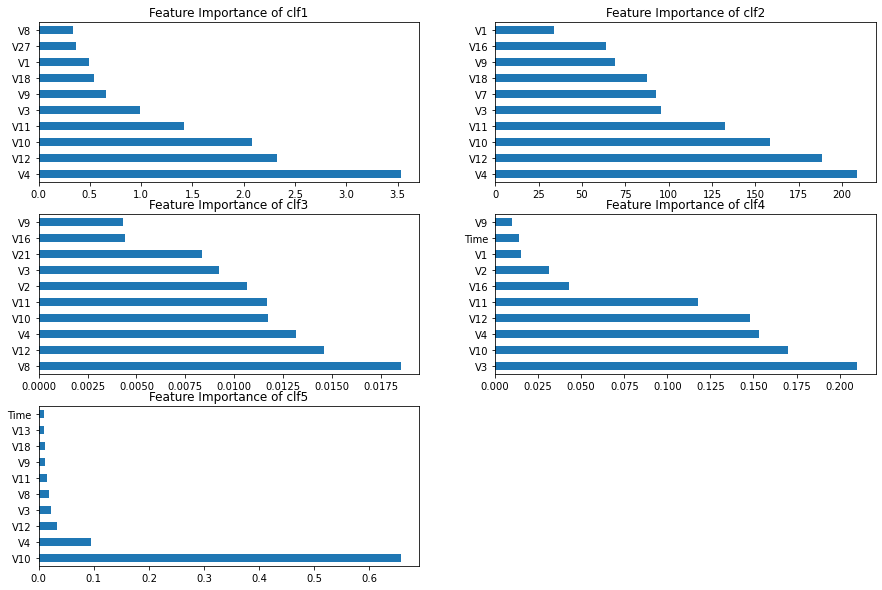

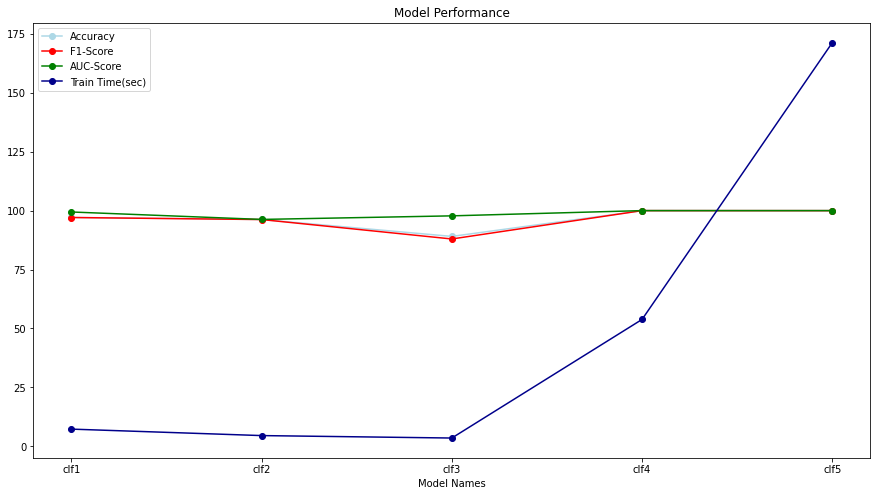

The selected classifiers are: 
1. clf1
2. clf2
3. clf4
4. clf5

Phase 3 Started
The final model is ready and has been evaluated the results are as following:
Accuracy : 0.9974763906230765
F1 Score : 0.9974716106809032
AUC Score:  0.9974755204805053
Average Precision : 0.9966901408450705
Average Recall : 0.9982543069245825
Compilation successful!


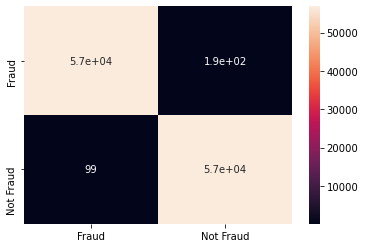

In [18]:
hybrid_model_formation(LogisticRegression(max_iter=1000), SGDClassifier(loss="modified_huber", penalty = "l2"), 
                      GaussianNB(), RandomForestClassifier(n_estimators=20, max_depth = 26), 
                       XGBClassifier(use_label_encoder=False, disable_default_eval_metric=1), X, Y, list(df.columns))